# Simulating a photon around a black hole
## 2D Case

This notebook relies on the equation:

$\frac{d^2u}{d\phi^2} = \frac{3}{2} r_s u^2 - u$

 Where $u = \frac{1}{r}$
 
 And $r_s$ is the Schwarzschild radius of the black hole: $r_s = \frac{2GM}{c^2}$
 
Let $v = \frac{du}{d\phi}$, then we can rewrite the equation as a system of first-order equations:

$\frac{du}{d\phi} = v$

<br>

$\frac{dv}{d\phi} = \frac{3}{2} r_s u^2 - u$

Let $x = \begin{bmatrix} u \\ v \end{bmatrix}$

Then we can write the system as:
$\frac{dx}{d\phi} = \begin{bmatrix} v \\ \frac{3}{2} r_s u^2 - u \end{bmatrix}$


In [110]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [111]:
# Since r_s is generally a really small number (under floating-point precision) we can set it to 1
R_S = 1


# Formatted for scipy's solve_ivp
def black_hole_ode(t, x):
    u, v = x
    du_dt = v
    dv_dt = (3/2) * R_S * u**2 - u
    return np.array([du_dt, dv_dt])

def escaped(t, x):
    u = x[0]
    r = 1 / u if u > 0 else np.inf
    return r - 50  # Stop when r > 50

escaped.terminal = True

# Event function: stop when photon falls into black hole (r < 1.5 * R_S)
def captured(t, x):
    u = x[0]
    r = 1 / u if u > 0 else np.inf
    return r - 1.5 * R_S  # Stop when r < 1.5 * R_S

captured.terminal = True
captured.direction = -1  # Only trigger when decreasing


In [112]:
# Initial conditions
r_0 = 10
u_0 = 1 / r_0

# v_0 = 0, photon velocity is tangential to the black hole. v_0 = inf, photon velocity is radial to the black hole.
v_0 = 0.365

initial_conditions = [u_0, v_0]

# Integration span
phi_span = (0, 20 * np.pi)
solution = solve_ivp(black_hole_ode, phi_span, initial_conditions,
                     t_eval=np.linspace(*phi_span, 1000),
                     events=[escaped, captured])


In [113]:
u_values = solution.y[0]
r_values = 1 / u_values
phi_values = solution.t

x_values = r_values * np.cos(phi_values)
y_values = r_values * np.sin(phi_values)

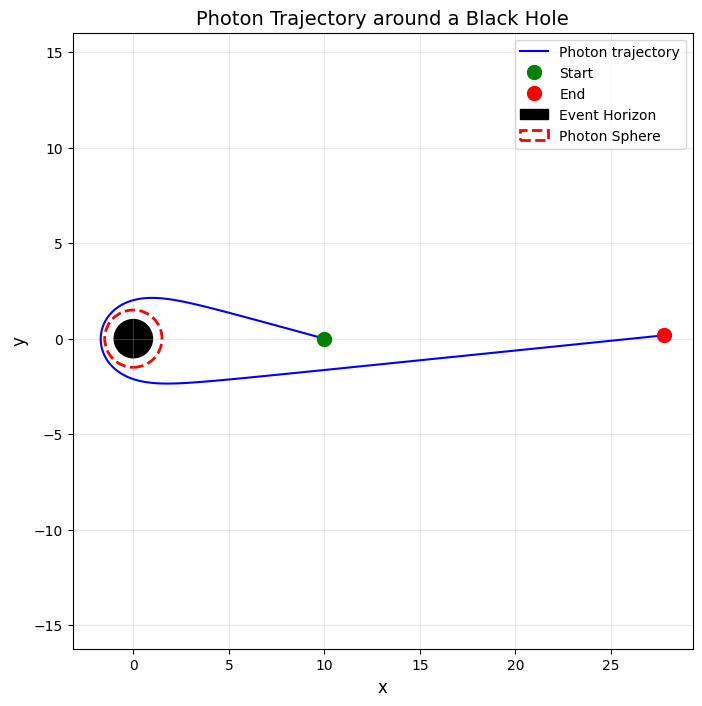

In [114]:
plt.figure(figsize=(8, 8))
plt.plot(x_values, y_values, 'b-', linewidth=1.5, label='Photon trajectory')

# Mark start and end points
plt.plot(x_values[0], y_values[0], 'go', markersize=10, label='Start')
plt.plot(x_values[-1], y_values[-1], 'ro', markersize=10, label='End')

# Draw the black hole event horizon
circle = plt.Circle((0, 0), R_S, color='black', label='Event Horizon')
plt.gca().add_patch(circle)

# Draw the photon sphere (unstable circular orbit at r = 1.5 * R_S)
photon_sphere = plt.Circle((0, 0), 1.5 * R_S, color='red', fill=False,
                           linestyle='--', linewidth=2, label='Photon Sphere')
plt.gca().add_patch(photon_sphere)

# Set equal aspect ratio and reasonable limits
plt.axis('equal')
# plt.xlim(-20, 20)
# plt.ylim(-20, 20)
plt.grid(True, alpha=0.3)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Photon Trajectory around a Black Hole', fontsize=14)
plt.legend(loc='upper right')

## Testing time requirement for rendering

Let's get a grasp on how long it takes per 1080*1920 integrations, which is required for rendering an image.

In [119]:
import timeit

t = timeit.timeit(
    lambda: solve_ivp(black_hole_ode, phi_span, initial_conditions),
    number=100
)
print(f"{t / 100:.5f} seconds per integration")
print(f"{t / 100 * 1080 * 1920 / 60 / 60:.2f} hours per 1080*1920 integrations")

0.00228 seconds per integration
1.31 hours per 1080*1920 integrations


Yikes! One image will take at *least* 1.33 hours, but probably more after all the other computations I need to do. For a final renderer, this must be implemented on the GPU (or at least in C++). 

## 3D Initial Condition

One requirement for rendering this in 3D is taking the 3D initial condition (ray position, $\vec{r_0}$, and direction, $\hat{d_0}$) and converting it to the 2D polar coodinate system. This requires finding the plane where all the good stuff happens and projecting the 3D stuff onto that plane.

The normal of that plane is defined as:

$$N=\vec{r_0} \times \hat{d_0}$$
$$\hat{N} = \frac{\vec{N}}{|N|}$$

Then we define two axes: radial ($e_r$) and tangential ($e_t$)

$$\vec{e_r} = \hat{r_0}$$
$$\vec{e_t} = \hat{N} \times e_r$$

Then, we will use:
$$u_0 = \frac{1}{|r_0|$$
$$\phi_0 = 0$$
$$v_0 = -\frac{d_r}{|r_0|d_t} = -\frac{\hat{d_0} \cdot \hat{e_r}}{|r_0|(\hat{d_0} \cdot \hat{e_t})}$$

